In [1]:
import socket
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd

from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import s2widthcut_utility as wcu
import math
from datetime import datetime, timedelta
import cutax
from straxen.get_corrections import get_correction_from_cmt
from cutax.cuts import *

%load_ext autoreload
%autoreload 2
#import importlib
#importlib.reload(cutax)

In [2]:
straxen.print_versions()

,module,version,path,git
0,python,3.8.13,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/b...,None
1,strax,1.2.3,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/l...,None
2,straxen,1.8.1,/opt/XENONnT/anaconda/envs/XENONnT_2022.06.1/l...,None
3,cutax,1.10.0,/dali/lgrandi/xenonnt/software/cutax/v1.10.0/c...,None


In [3]:
st = cutax.contexts.xenonnt_v8(cut_list=[cutax.cut_lists.basic.BasicCuts])
FiducialVolume = st.get_single_plugin('030000', 'cut_fiducial_volume')
NearWires = st.get_single_plugin('030000', 'cut_near_wires')

In [4]:
ev_rn220 = pd.read_pickle('/dali/lgrandi/kazama/xenonnt/analysis/er_leakage/v8/Rn220_20220619_v8_20220502_new_s2_width_s1_ss.pkl')
#ev_rn220 = pd.read_pickle('/dali/lgrandi/kazama/xenonnt/analysis/er_leakage/v8/Rn220_20220502_cutax_110.pkl')
evRn = ev_rn220[wcu.all_cuts(ev_rn220)]

In [5]:
ev_sim = np.load('/dali/lgrandi/shenyangshi/bdt_acceptance_0620.npy', allow_pickle=True).item()
ev_sim, ev_beta, ev_alpha = ev_sim['wfsim'], ev_sim['bkg_beta'], ev_sim['bkg_alpha']
ev_sim = ev_sim[FiducialVolume.cut_by(ev_sim)]

In [6]:
vd = get_correction_from_cmt('024075',('electron_drift_velocity', 'ONLINE', True))
gd = get_correction_from_cmt('024075',('electron_drift_time_gate', 'ONLINE', True))
dc = get_correction_from_cmt('024075',('electron_diffusion_cte', 'ONLINE', True))
par = (dc,vd,gd)
print(par)

(4.566e-08, 6.77e-05, 2700.0)


Fit lower boundary: [0.75785949 3.18263529 1.26349891]
Fit upper boundary: [4.74467848 1.34106577 1.99650474 1.02559667]


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:605: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


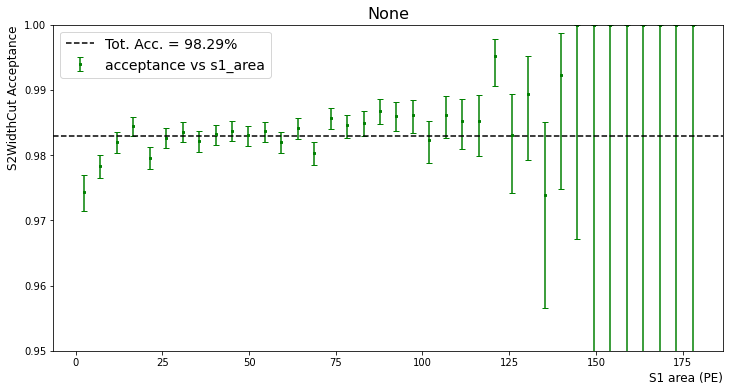

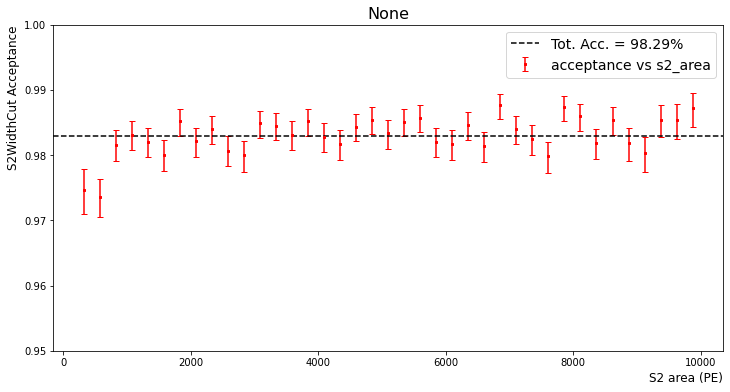

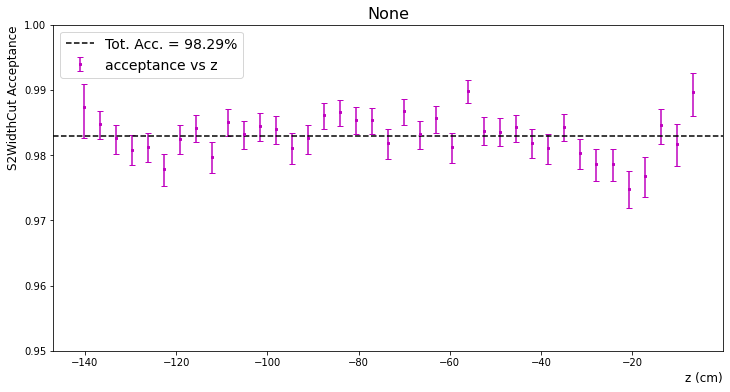

In [7]:
# FAR FROM WIRES 1-99%
cut_far, acc_sim_f = wcu.set_cut_on_data(ev_sim, par, width_type='50p', perc=(1,99),wrange=(0,6),
                                          alim=(0.95,1), afit=(2,4), acc_calc = 1)

Fit lower boundary: [0.7742574  2.92714807 1.22338626]
Fit upper boundary: [4.74467848 1.34106577 1.99650474 1.02559667]


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:605: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


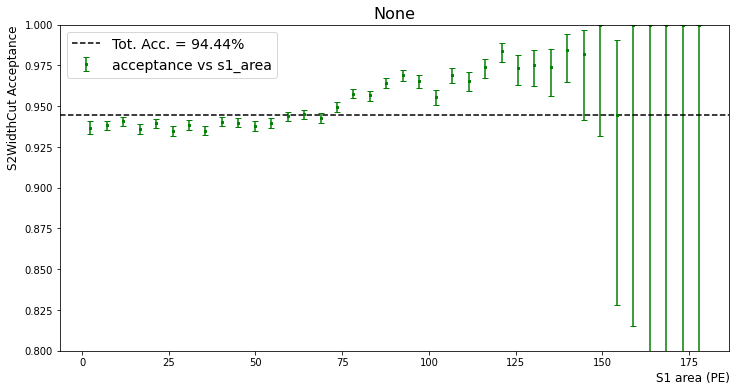

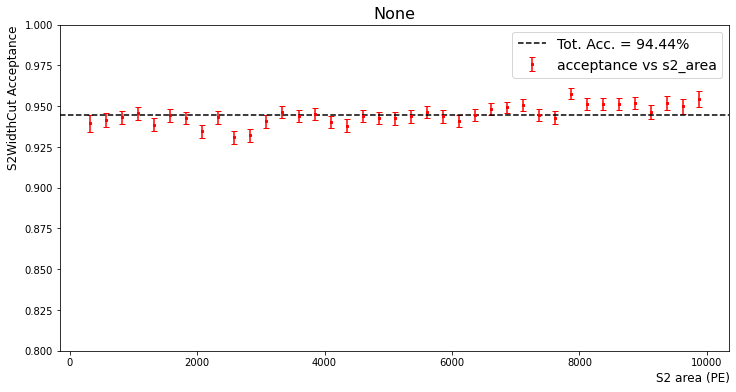

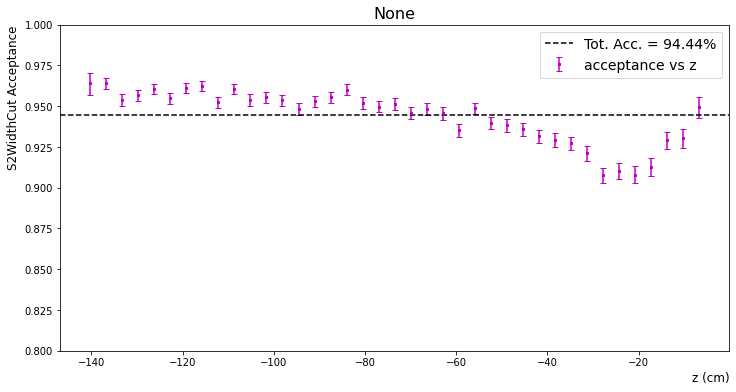

In [8]:
# NEAR WIRES WIMPs
cut_near, acc_sim_n = wcu.set_cut_on_data(ev_sim, par, width_type='50p',perc=(5,99),wrange=(0,6),
                                           alim=(0.8,1), afit=(2.,4), acc_calc=1)

In [9]:
# get cut mask for WFsim near wires for LowER 1-99%
cut_mask_sim_low_er_near = wcu.S2WidthCut(ev_sim, title='WFsim near wires', mod_par=par, bins=400,
                                          wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0,
                                          ext_par=cut_far, near_wires=1, wire_model=1 )
cut_mask_sim_low_er_near = cut_mask_sim_low_er_near[1]
# get cut mask for WFsim far from wires for LowER 1-99%
cut_mask_sim_low_er_far = wcu.S2WidthCut(ev_sim, title='WFsim far wires', mod_par=par, bins=400,
                                        wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0,
                                        ext_par=cut_far)
cut_mask_sim_low_er_far = cut_mask_sim_low_er_far[1]
mask_near_wires = NearWires.cut_by(ev_sim)
cut_mask_sim_low_er_near[~mask_near_wires] = True
cut_mask_sim_low_er_far[mask_near_wires] = True 
cut_mask_sim_low_er = cut_mask_sim_low_er_near & cut_mask_sim_low_er_far

In [10]:
# get cut mask for WFsim near wires for WIMPs 1-99%
cut_mask_sim_wimps_near = wcu.S2WidthCut(ev_sim, title='WFsim near wires', mod_par=par, bins=400,
                                          wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0,
                                          ext_par=cut_far, near_wires=1, wire_model=1 )
cut_mask_sim_wimps_near = cut_mask_sim_wimps_near[1]
# get cut mask for WFsim far from wires for WIMPs 5-99%
cut_mask_sim_wimps_far = wcu.S2WidthCut(ev_sim, title='WFsim far wires', mod_par=par, bins=400,
                                        wrange=(0,6), arange = (2.2,6.5), plot = 0, perc_plot=0,
                                        ext_par=cut_near)
cut_mask_sim_wimps_far = cut_mask_sim_wimps_far[1]
mask_near_wires = NearWires.cut_by(ev_sim)
cut_mask_sim_wimps_near[~mask_near_wires] = True
cut_mask_sim_wimps_far[mask_near_wires] = True 
cut_mask_sim_wimps = cut_mask_sim_wimps_near & cut_mask_sim_wimps_far

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:605: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


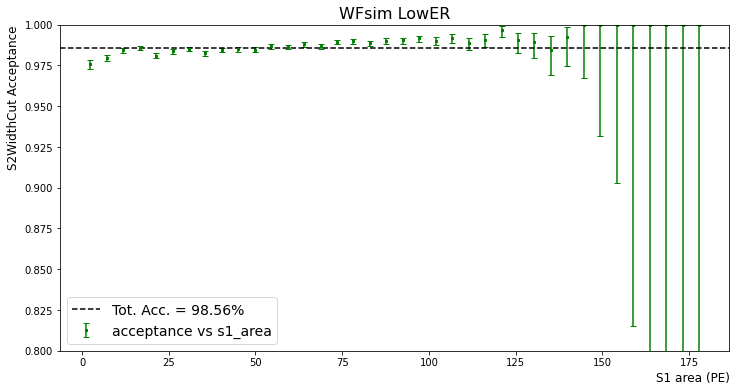

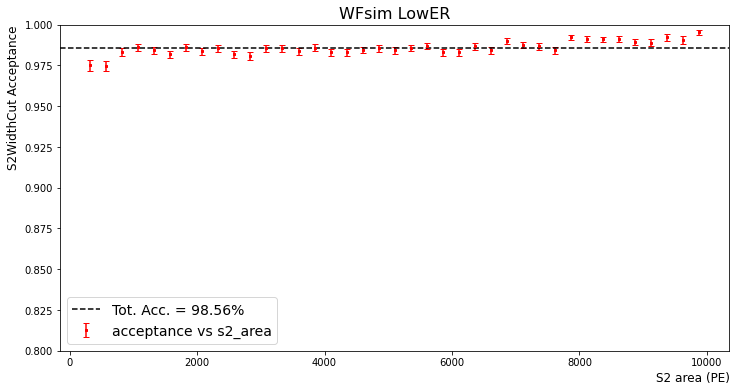

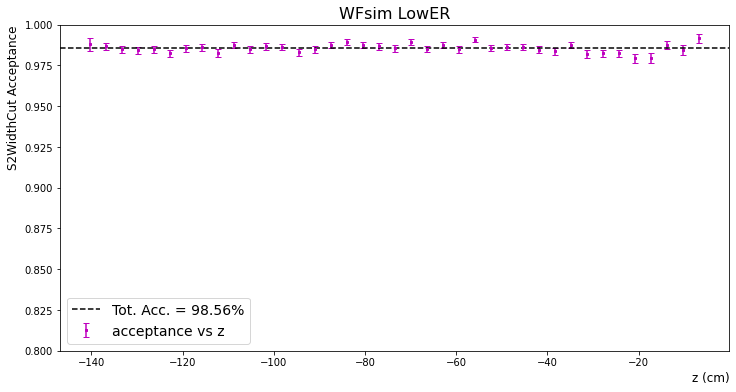

In [11]:
acc_sim_low_er = wcu.get_acceptance(ev_sim, cut_mask_sim_low_er, title='WFsim LowER', alim=(0.8,1))

/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:605: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),


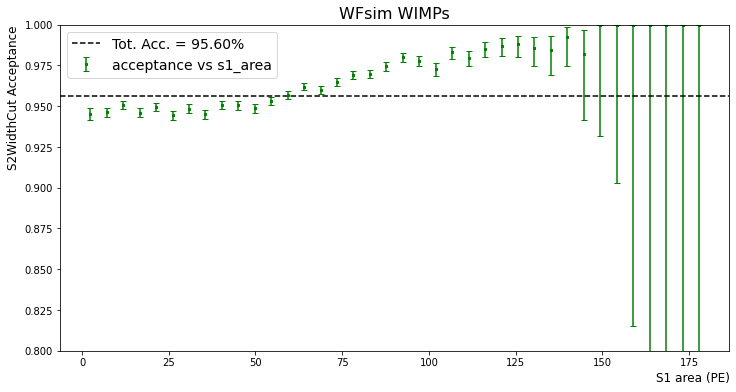

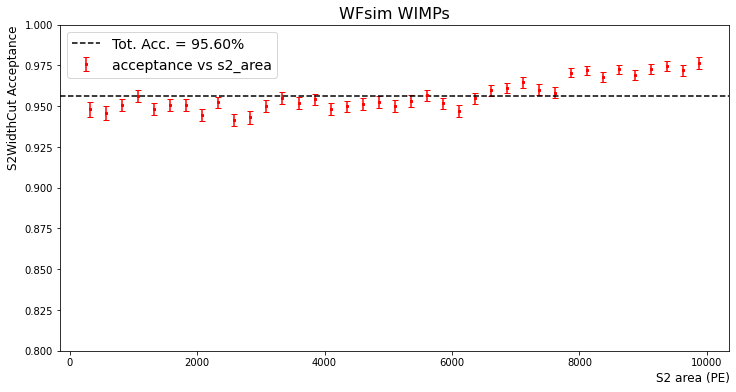

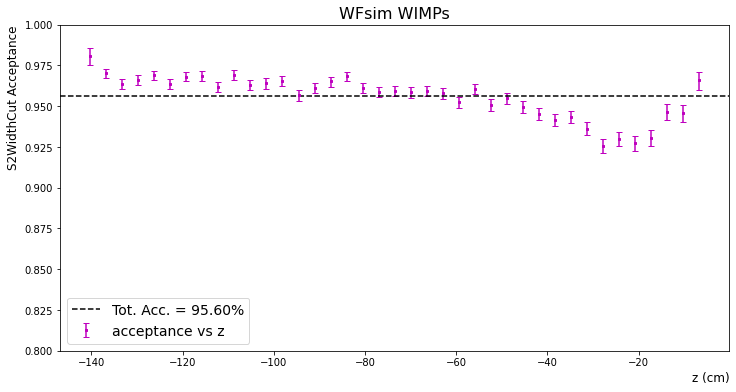

In [12]:
acc_sim_wimps = wcu.get_acceptance(ev_sim, cut_mask_sim_wimps, title='WFsim WIMPs', alim=(0.8,1))

Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634788 0.19632396]
param_parabola_high: [ 0.12086412 -1.22950531  4.37592357]
Cut: total 442474, survived 342011 -> 77.30%


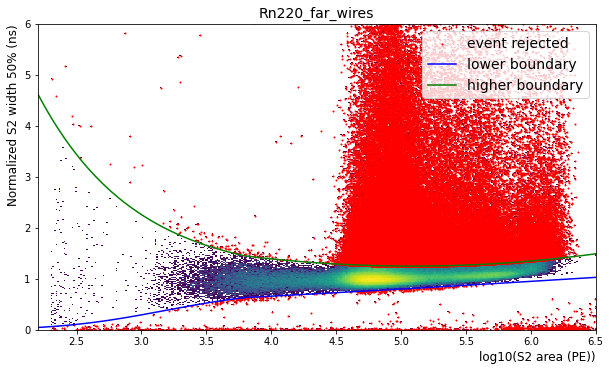

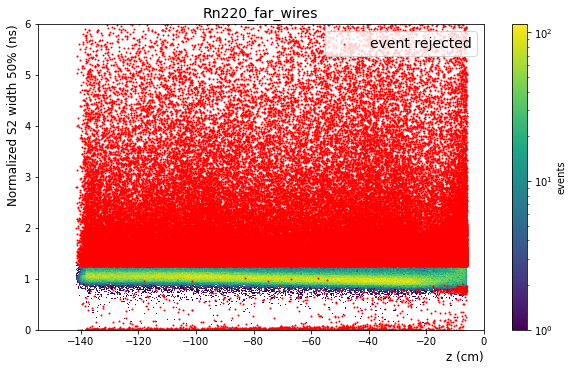

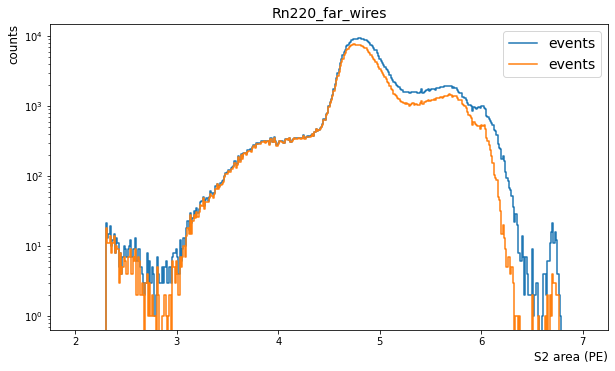

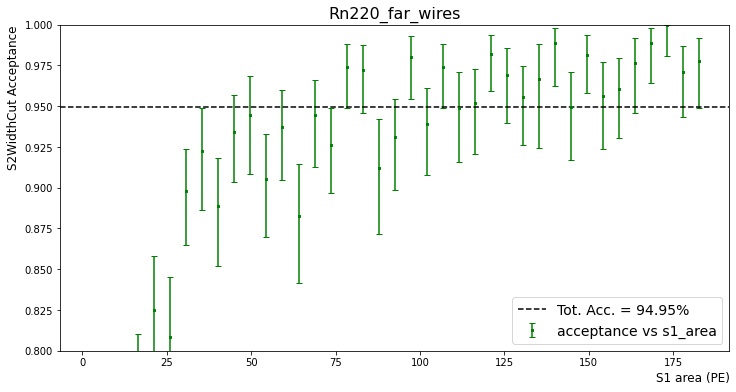

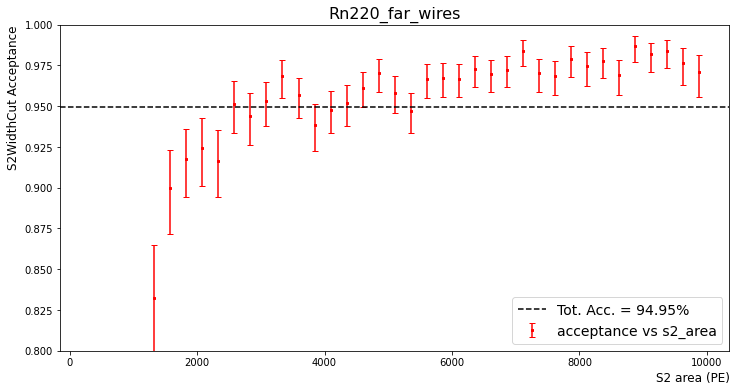

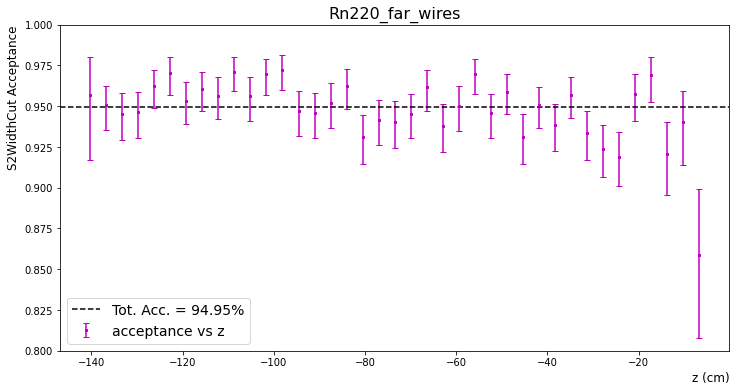

In [31]:
acc_f = wcu.apply_cut_on_data(evRn, par, cut_far, width_type = '50p', far_wires = 1, wrange = (0,6),
                      acc_calc = 1, alim=(0.8,1),plot=1, info = 'Rn220_far_wires')

Lower and higher boundary provided externally
param_parabola_low: [ 0.03578608 -0.24364693  1.12358253]
param_parabola_high: [ 0.12086412 -1.22950531  4.37592357]
Cut: total 89797, survived 89165 -> 99.30%
Cut wire modeled: total 89797, survived 77216 -> 85.99%


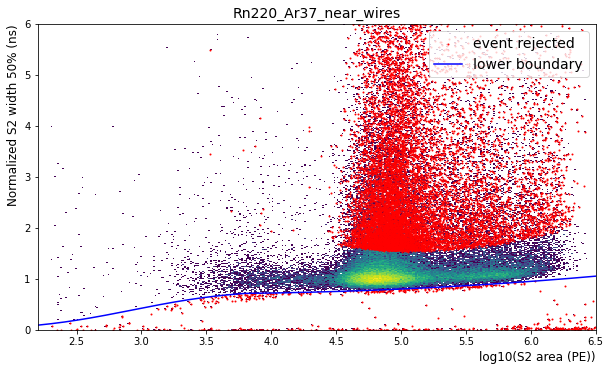

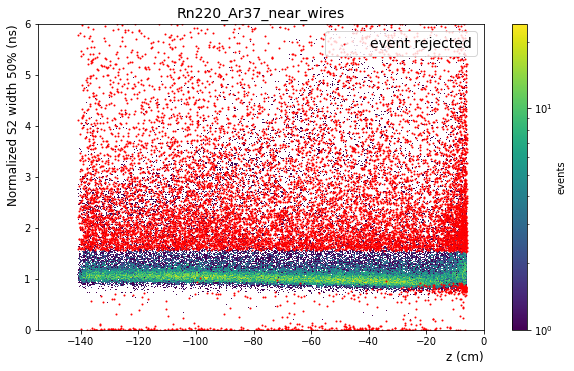

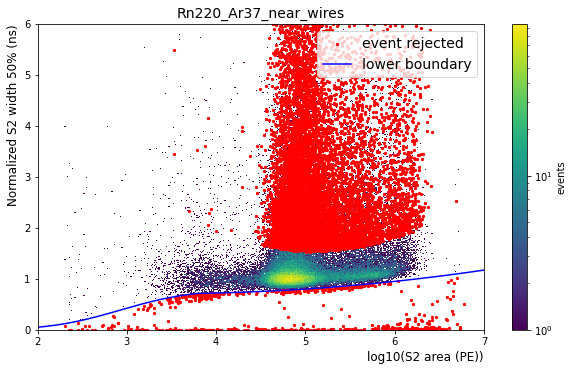

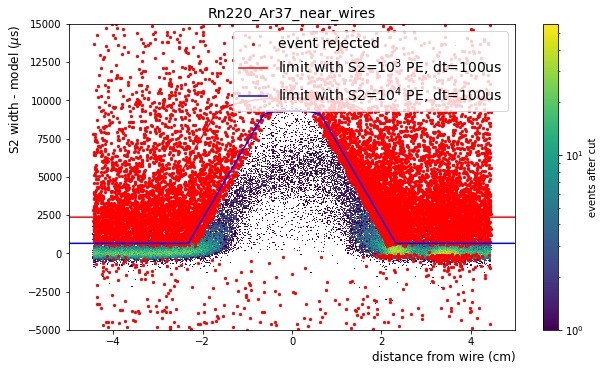

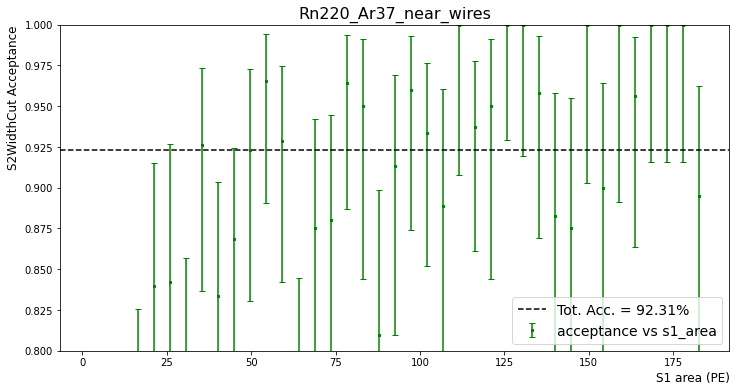

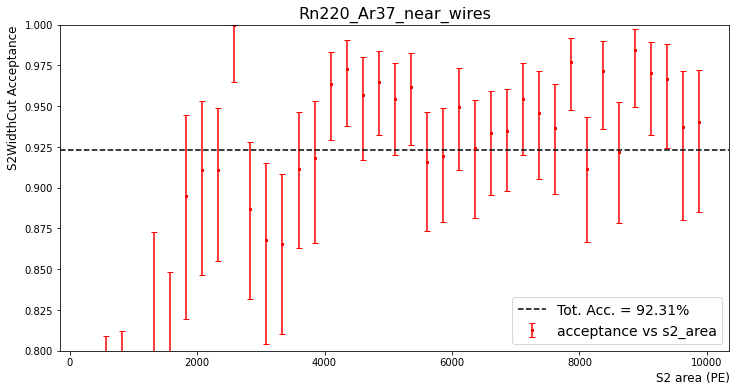

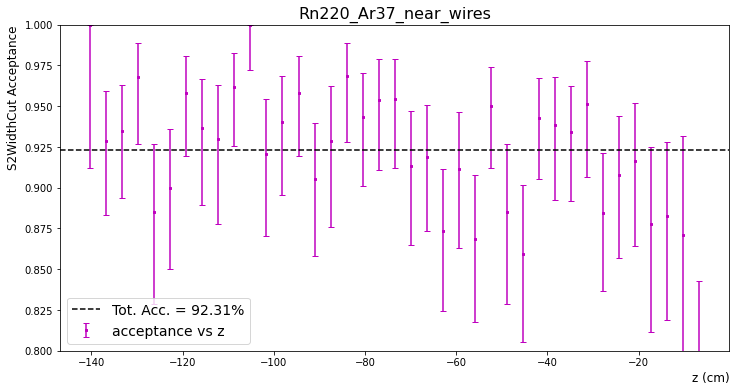

In [21]:
acc_n = wcu.apply_cut_on_data(evRn, par, cut_near, width_type = '50p', near_wires = 1, wrange = (0,6),
                      acc_calc = 1, alim=(0.8,1), info = 'Rn220_Ar37_near_wires',wire_model=1,plot=1)

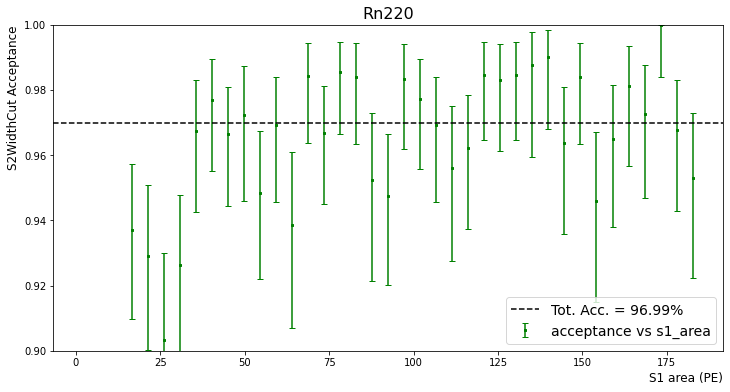

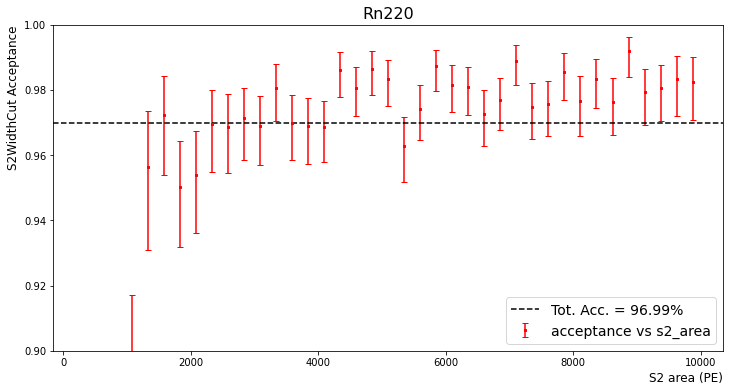

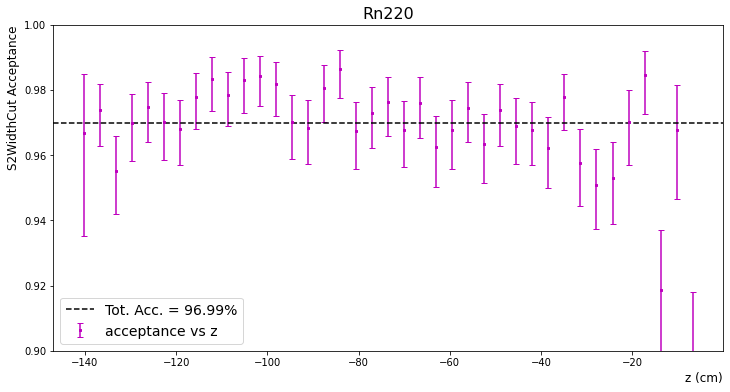

In [14]:
ev_low_er = ev_rn220[wcu.all_cuts(ev_rn220,low_er=1)]
acc_low_er = wcu.get_acceptance(ev_low_er, ev_low_er['cut_s2_width_wire_modeled_low_er'], title='Rn220')

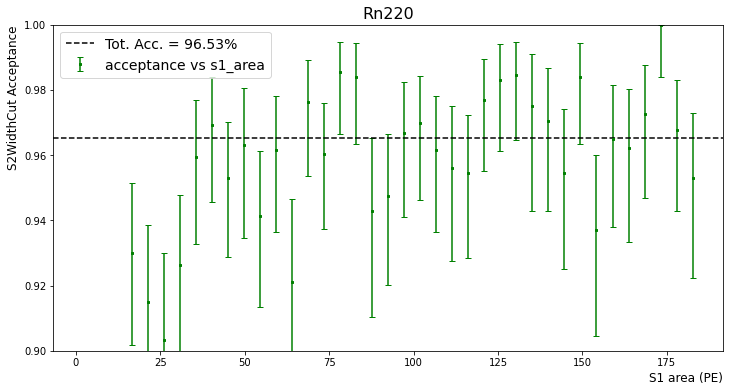

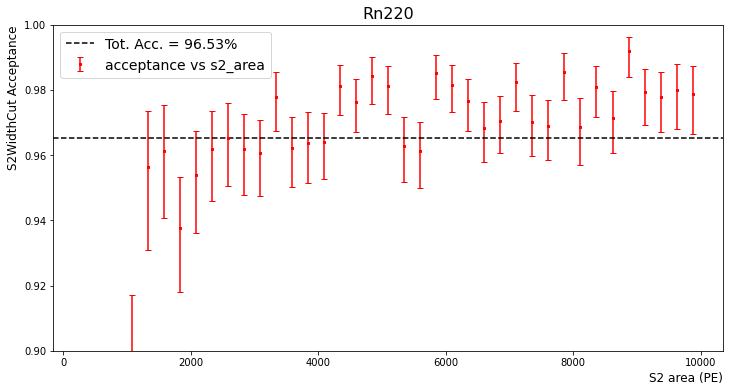

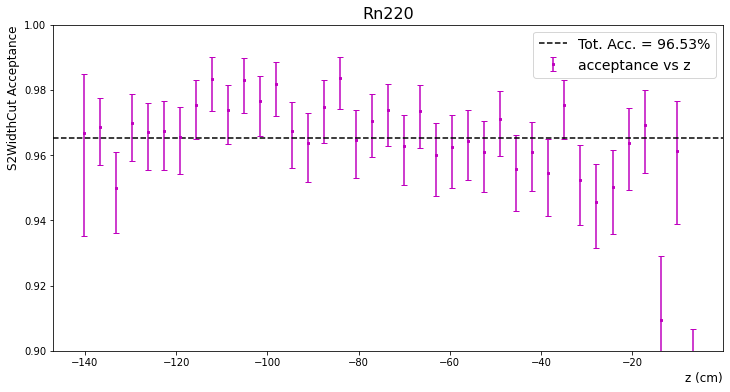

In [16]:
ev_wimps = ev_rn220[wcu.all_cuts(ev_rn220,wimps=1)]
acc_wimps = wcu.get_acceptance(ev_wimps, ev_wimps['cut_s2_width_wire_modeled_wimps'], title='Rn220')

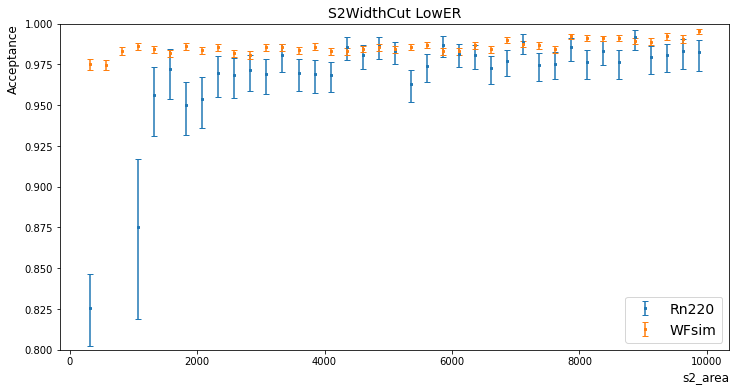

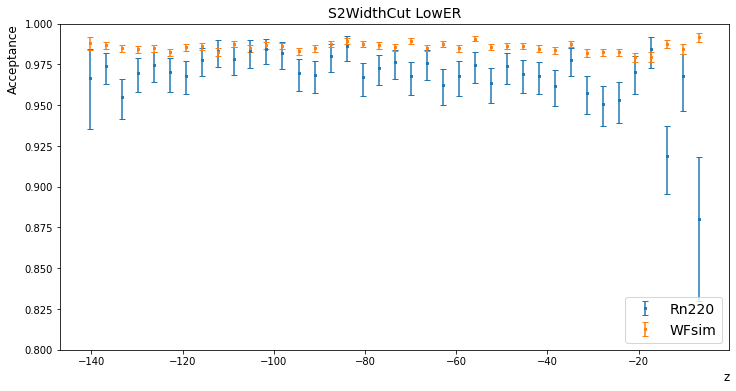

In [17]:
wcu.plot_acceptance(acc_low_er, acc_sim_low_er, alim=(0.8,1),title='S2WidthCut LowER',info='Rn220')

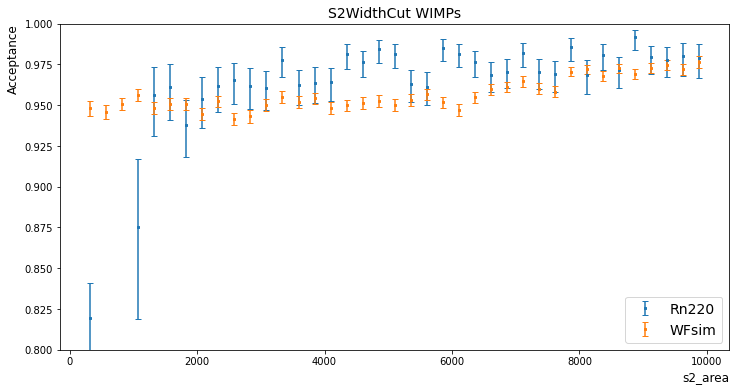

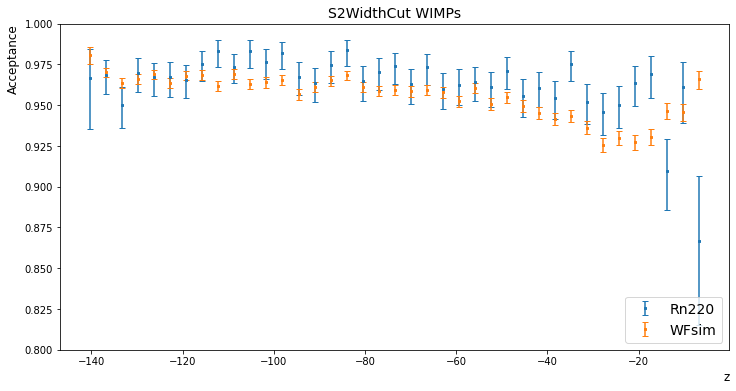

In [18]:
wcu.plot_acceptance(acc_wimps, acc_sim_wimps, alim=(0.8,1),title='S2WidthCut WIMPs',info='Rn220')

Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634788 0.19632396]
param_parabola_high: [ 0.12086552 -1.22952077  4.37596573]
Cut: total 439848, survived 340652 -> 77.45%


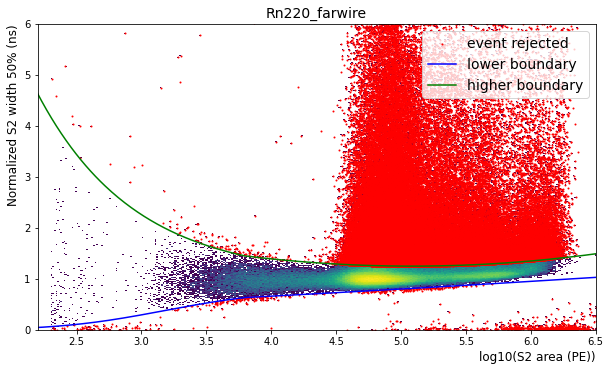

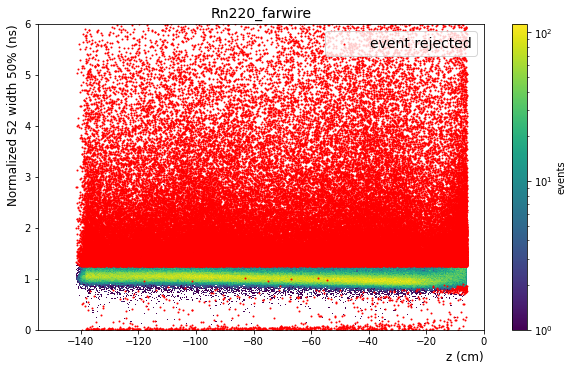

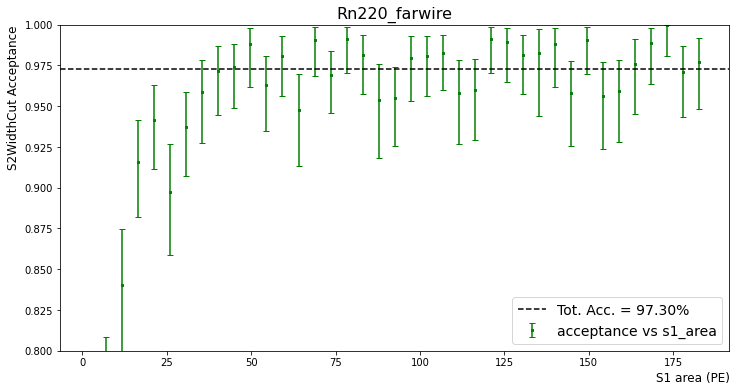

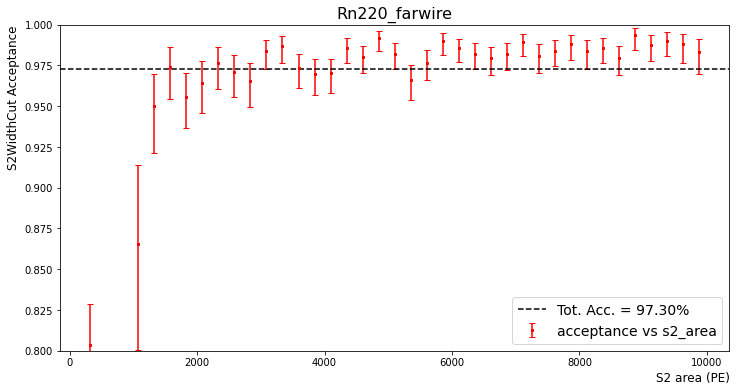

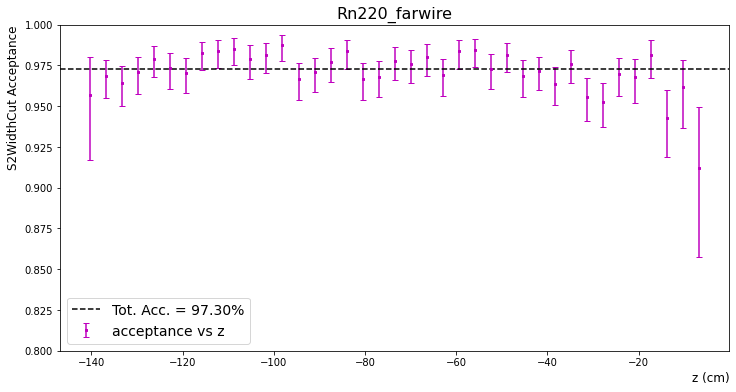

In [38]:
# FAR WIRES Rn-220
wcu.apply_cut_on_data(evRn, par, cut_far, width_type = '50p', far_wires = 1, wrange = (0,6),
                      acc_calc = 1,plot=1, alim=(0.8,1), info = 'Rn220_farwire')

Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634788 0.19632396]
param_parabola_high: [ 0.12086552 -1.22952077  4.37596573]
Cut: total 89159, survived 88789 -> 99.59%


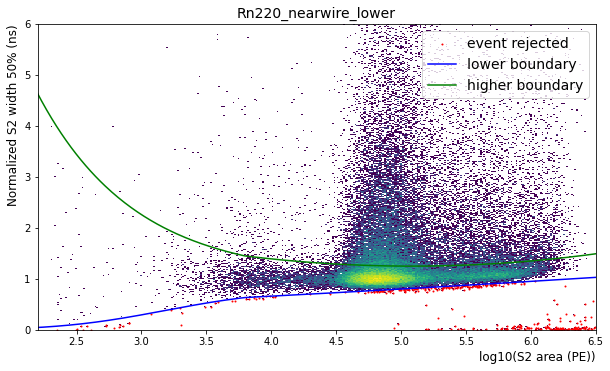

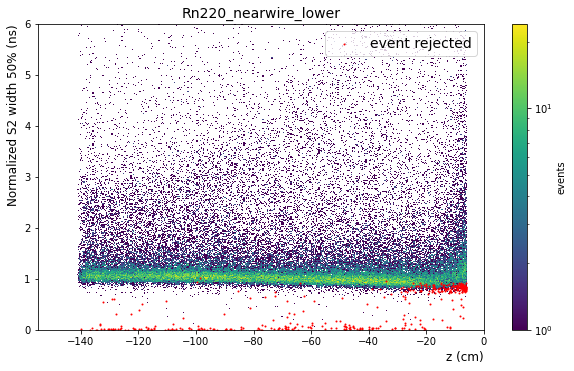

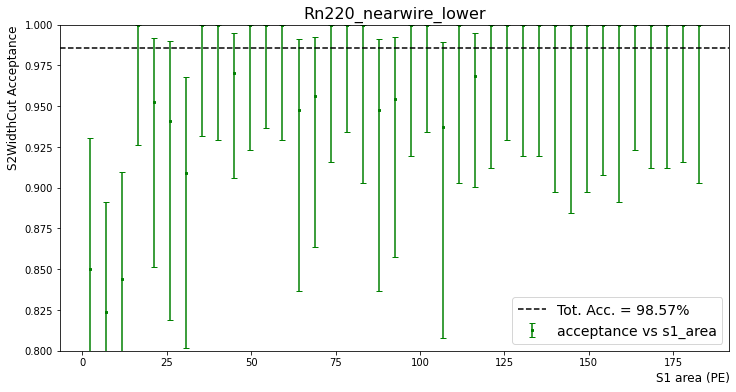

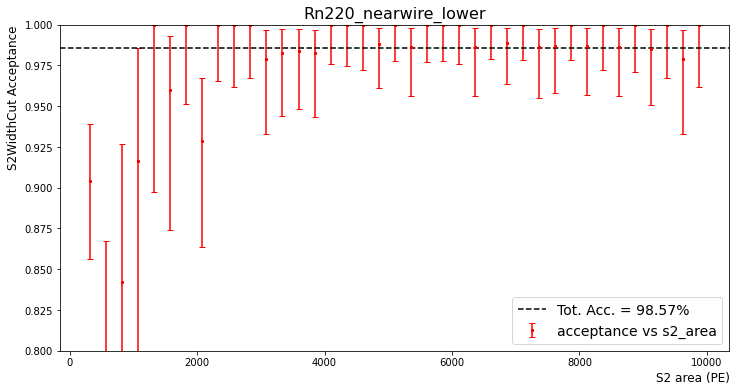

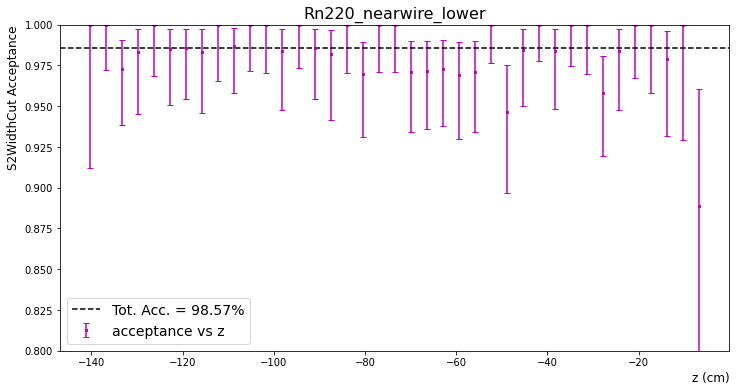

In [41]:
# NEAR WIRES Rn-220
wcu.apply_cut_on_data(evRn, par, cut_far, width_type = '50p', near_wires = 1, wrange = (0,6),
                      acc_calc = 1, alim=(0.8,1), info = 'Rn220_nearwire_lower',plot=1)